# Election Results

I got bored refreshing websites and trying to guess what was gonna happen based on the opinions of people on TV. I decided to take matters into my own hand and collect data and see what it said was going to happen.

In another script I pulled state polling data from the Fox News API for the total number of votes by candidate. THe reason I used Fox News was that they updated totals faster. 

These results are stored in a "pseudo Data Lake" in the "election-results" folder.
I want to look at only Pennsylvania, Nevada, Arizona, and Georgia

In [67]:
folder_path = "./election-results/"
battlegrounds = ["NV", "PA", "AZ", "GA"]

Lets parse the files downloaded. 

In [68]:
import os
from datetime import datetime
import json
import pandas as pd

def count_votes(state):
    trump = 0
    biden = 0
    other = 0
    for r in state["results"]:
        votes = r["votes"]["count"]
        candidateID = r["candidateNpid"]
        if candidateID == 8639:
            trump += votes
        elif candidateID == 1036:
            biden += votes
        else:
            other += votes
    return trump, biden, other

totals = []
file_names = os.listdir(folder_path)
for file_name in file_names:    
    time_stamp = datetime.fromtimestamp(float(file_name[7:-5]))
    file = open(folder_path+file_name, 'r')
    results = json.loads(file.read())
    state_results = results["stateResults"]
    # Get Results from Files
    for state in state_results:
        state_code = state["stateCode"]
        if state_code in battlegrounds:

            (trump, biden, other) = count_votes(state)
            total = sum((trump, biden, other))
            percent = state["expectedPercentage"]

            poll = pd.Series({ 'Time' : time_stamp,
                            'State' : state_code,
                            'Progress' : percent / 100,
                            'Total' : total,
                            'Trump Share' : trump / total,
                            'Trump Vote' : trump,
                            'Biden Share' : biden / total,
                            'Biden Vote' : biden,
                            'Other Share' : other / total,
                            'Other Vote' : other})
            totals.append(poll)
print(totals[:5])

[Time           2020-11-05 10:52:28.864410
State                                  AZ
Progress                             0.88
Total                             2910053
Trump Share                          0.48
Trump Vote                        1400951
Biden Share                          0.50
Biden Vote                        1469341
Other Share                          0.01
Other Vote                          39761
dtype: object, Time           2020-11-05 10:52:28.864410
State                                  GA
Progress                             0.99
Total                             4908120
Trump Share                          0.50
Trump Vote                        2432925
Biden Share                          0.49
Biden Vote                        2414781
Other Share                          0.01
Other Vote                          60414
dtype: object, Time           2020-11-05 10:52:28.864410
State                                  NV
Progress                             0.75
Tot

Now we have our count over time in a data frame, but we need to transpose it.

In [69]:
data = pd.concat(totals, axis=1).T

print(data)

                           Time State Progress    Total Trump Share  \
0    2020-11-05 10:52:28.864410    AZ     0.88  2910053        0.48   
1    2020-11-05 10:52:28.864410    GA     0.99  4908120        0.50   
2    2020-11-05 10:52:28.864410    NV     0.75  1192557        0.49   
3    2020-11-05 10:52:28.864410    PA     0.87  6386689        0.50   
4    2020-11-05 11:22:29.041940    AZ     0.88  2910053        0.48   
...                         ...   ...      ...      ...         ...   
2803 2020-11-11 13:18:20.880688    PA     0.99  6787297        0.49   
2804 2020-11-11 13:29:28.687725    AZ     0.99  3348584        0.49   
2805 2020-11-11 13:29:28.687725    GA     0.99  4991742        0.49   
2806 2020-11-11 13:29:28.687725    NV     0.95  1337217        0.47   
2807 2020-11-11 13:29:28.687725    PA     0.99  6787297        0.49   

     Trump Vote Biden Share Biden Vote Other Share Other Vote  
0       1400951        0.50    1469341        0.01      39761  
1       2432925    

## Time Travel

Lets rewind to Thursday Nov. 5 (2 days after the election)

In [70]:
data = data[(data['Time'] < '2020-11-06')]
print(data)

                          Time State Progress    Total Trump Share Trump Vote  \
0   2020-11-05 10:52:28.864410    AZ     0.88  2910053        0.48    1400951   
1   2020-11-05 10:52:28.864410    GA     0.99  4908120        0.50    2432925   
2   2020-11-05 10:52:28.864410    NV     0.75  1192557        0.49     580605   
3   2020-11-05 10:52:28.864410    PA     0.87  6386689        0.50    3224422   
4   2020-11-05 11:22:29.041940    AZ     0.88  2910053        0.48    1400951   
..                         ...   ...      ...      ...         ...        ...   
283 2020-11-05 23:46:58.239968    PA     0.94  6617374        0.50    3282826   
284 2020-11-05 23:56:58.365637    AZ     0.90  3053134        0.49    1482062   
285 2020-11-05 23:56:58.365637    GA     0.99  4954180        0.49    2447343   
286 2020-11-05 23:56:58.365637    NV     0.84  1222331        0.48     592813   
287 2020-11-05 23:56:58.365637    PA     0.94  6618628        0.50    3283184   

    Biden Share Biden Vote 

Great, so theres the data. I can now being to make predictions based upon some assumptions. 

### Theory : The total, rate, and % of total votes are counted can predict the final count of votes 

Lets establish a basic slope and intercept of a dataset. And a function to calculate a regression line to make predictions

In [71]:
from statistics import mean

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
        (((mean(xs)*mean(xs)) - mean(xs*xs)) + 0.000001))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

def calculate_regression(xs, ys):
    m, b = best_fit_slope_and_intercept(xs,ys)
    r = [(m*x)+b for x in xs]
    return r

Im not good at stats, can I see this in action?

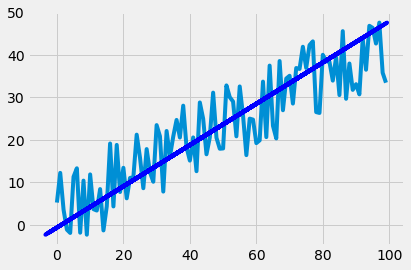

In [72]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
x = np.arange(100)
delta = np.random.uniform(-10,10, size=(100,))
y = .4 * x +3 + delta
r = calculate_regression(y,x)
plt.plot(x,y)
plt.plot(r, y, color='#0000FF', label='regression line')

plt.show() 

## Helper Functions

### Rolling Apply
This method will apply a function to a dataframe. This will be useful to calculate historical regression later

In [73]:
def rolling_apply(df, period, func, min_periods=None):
    if min_periods is None:
        min_periods = period
    result = pd.Series(np.nan, index=df.index)

    for i in range(1, len(df)+1):
        sub_df = df.iloc[0:i,:] #I edited here
        if len(sub_df) >= min_periods:
            idx = sub_df.index[-1]
            result[idx] = func(sub_df)
    return result

### Predict Votes

This method will:
- Take in votes for the Democrats and Republicans
- Calculate Regression for each party
- Use Regression to calculate the total once all the votes are in (predict_x)

In [74]:
def predict_votes(dem_votes, rep_votes, progress):
    predict_x = 1
    m, b = best_fit_slope_and_intercept(progress,dem_votes)
    m2, b2 = best_fit_slope_and_intercept(progress,rep_votes)
    predict_dem = (m*predict_x)+b
    predict_rep = (m2*predict_x)+b2
    return predict_dem, predict_rep

### Roll Democrats

Take in a dataframe with Trump and Biden Votes and make a prediction of the democrat total in the end

In [75]:
def roll_dem(df):
    dem_votes = df['Biden Vote']
    rep_votes = df['Trump Vote']
    ys = df['Progress']
    predict_dem, predict_rep = predict_votes(dem_votes, rep_votes, ys)
    return predict_dem

### Roll Republicans

Take in a dataframe with Trump and Biden Votes and make a prediction of republican total in the end

In [76]:
def roll_rep(df):
    dem_votes = df['Biden Vote']
    rep_votes = df['Trump Vote']
    ys = df['Progress']
    predict_dem, predict_rep = predict_votes(dem_votes, rep_votes, ys)
    return predict_rep


## Time to make predictions!

In [77]:
predicted = []
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_data["Biden Projection"] = rolling_apply(state_data, 50, roll_dem)
    state_data["Trump Projection"] = rolling_apply(state_data, 50, roll_rep)
    predicted.append(state_data)

data = pd.concat(predicted)
pd.options.display.float_format = '{:,.2f}'.format
print(data)

                          Time State Progress    Total Trump Share Trump Vote  \
0   2020-11-05 10:52:28.864410    AZ     0.88  2910053        0.48    1400951   
4   2020-11-05 11:22:29.041940    AZ     0.88  2910053        0.48    1400951   
8   2020-11-05 11:52:29.186225    AZ     0.88  2910053        0.48    1400951   
12  2020-11-05 12:22:29.322993    AZ     0.88  2910053        0.48    1400951   
16  2020-11-05 12:39:32.892565    AZ     0.88  2910053        0.48    1400951   
..                         ...   ...      ...      ...         ...        ...   
271 2020-11-05 23:16:57.836490    PA     0.90  6613509        0.50    3281842   
275 2020-11-05 23:26:57.961863    PA     0.90  6617374        0.50    3282826   
279 2020-11-05 23:36:58.100002    PA     0.90  6617374        0.50    3282826   
283 2020-11-05 23:46:58.239968    PA     0.94  6617374        0.50    3282826   
287 2020-11-05 23:56:58.365637    PA     0.94  6618628        0.50    3283184   

    Biden Share Biden Vote 

Awesome Lets plot these out

In [78]:
plt.style.use('fivethirtyeight') # For better style

color_dem = '#0000FF'
color_rep = '#FF0000'
color_pred_dem = '#AAAAFF'
color_pred_rep = '#FFAAAA'

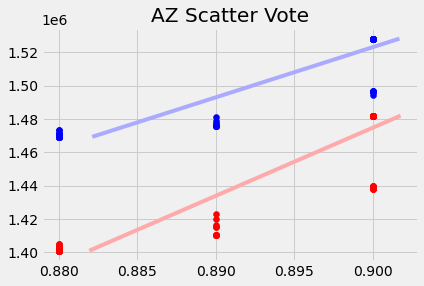

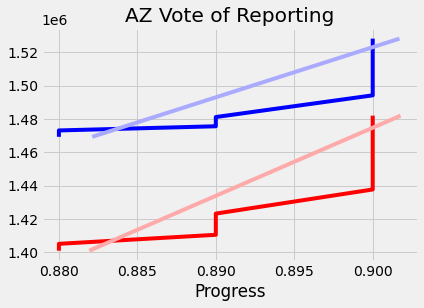

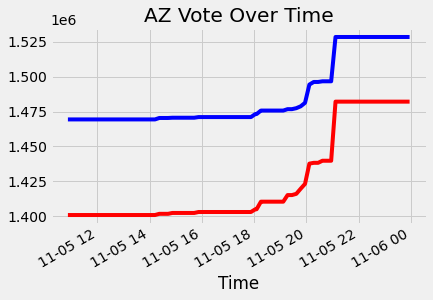

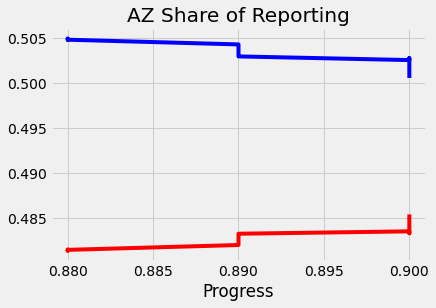

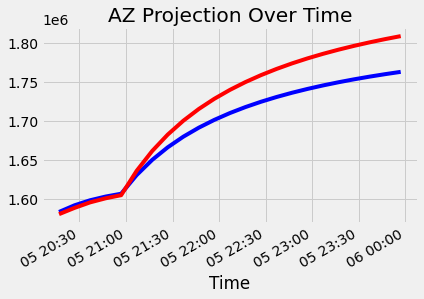

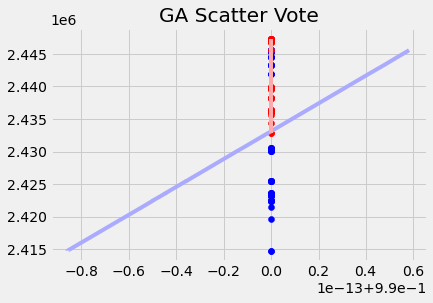

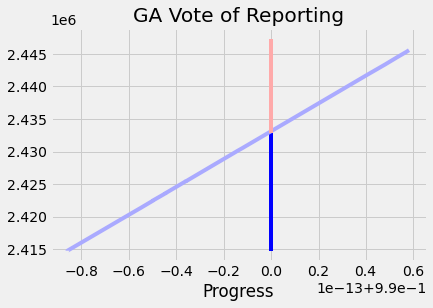

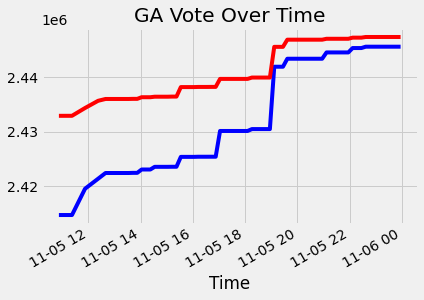

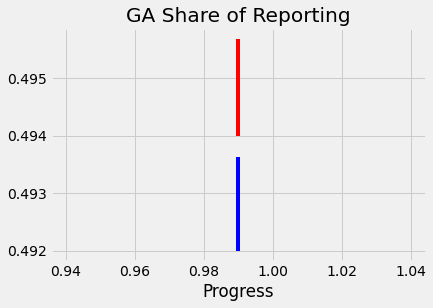

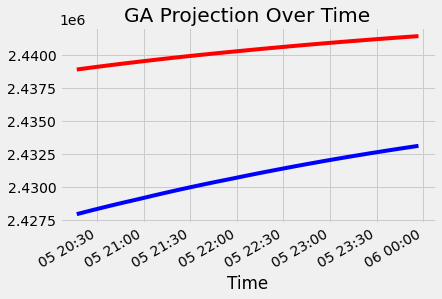

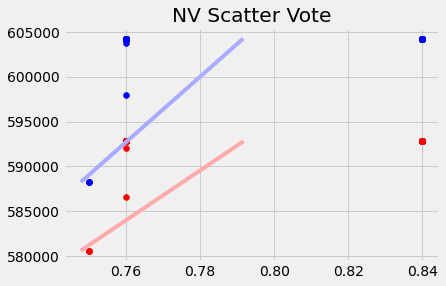

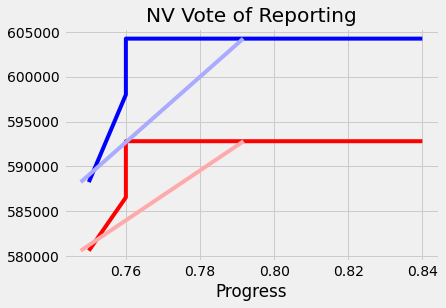

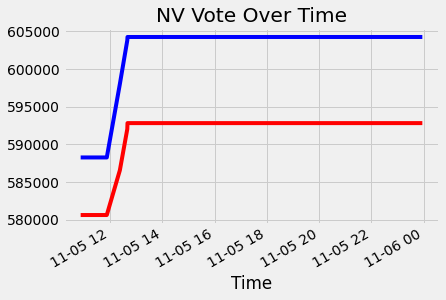

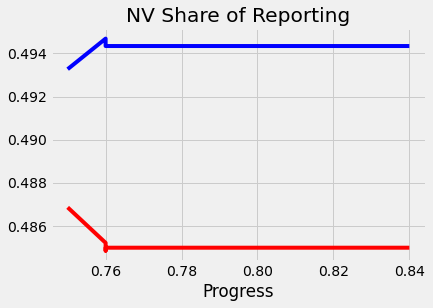

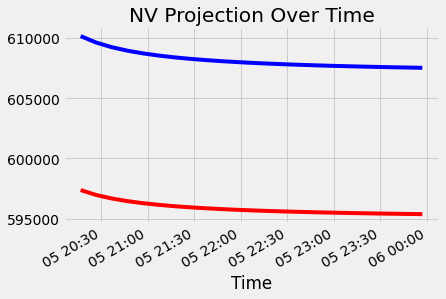

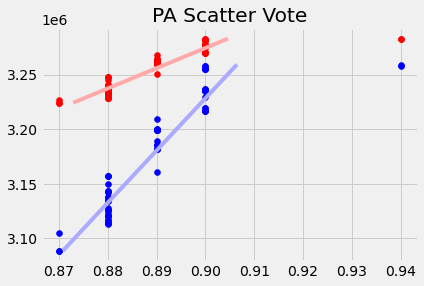

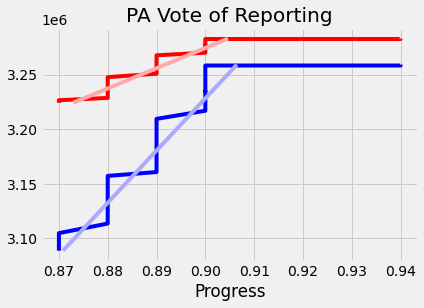

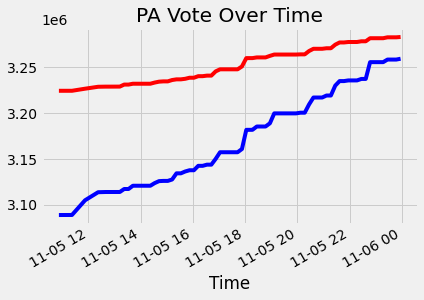

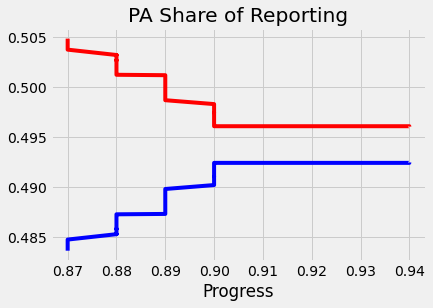

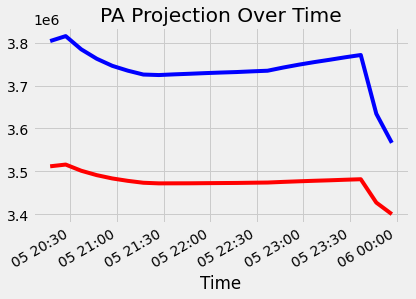

In [79]:
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_code = state_group[0]

    dem_votes = state_data['Biden Vote']
    rep_votes = state_data['Trump Vote']
    ys = state_data['Progress']

    regression_line_dem = calculate_regression(dem_votes, ys)
    regression_line_rep = calculate_regression(rep_votes, ys)

    #Scatter
    plt.scatter(ys,dem_votes,color=color_dem,label='data')
    plt.scatter(ys,rep_votes,color=color_rep,label='data')
    plt.plot(regression_line_dem, dem_votes, color=color_pred_dem, label='regression line')
    plt.plot(regression_line_rep, rep_votes, color=color_pred_rep, label='regression line')
    plt.title(state_code + ' Scatter Vote')
    plt.show()

    #Votes v Progress
    state_data.plot(y=['Biden Vote', 'Trump Vote'], color=[color_dem, color_rep], x='Progress', legend=None)
    plt.plot(regression_line_dem,dem_votes, color=color_pred_dem, label='regression line')
    plt.plot(regression_line_rep,rep_votes, color=color_pred_rep, label='regression line')
    plt.title(state_code + ' Vote of Reporting')

    plt.show()
    #Votes over Time
    state_data.plot(y=['Biden Vote', 'Trump Vote'], color=[color_dem, color_rep],x='Time', legend=None)
    plt.title(state_code + ' Vote Over Time')

    plt.show()
    #Share over Time
    state_data.plot(y=['Biden Share', 'Trump Share'], color=[color_dem, color_rep],x='Progress', legend=None)
    plt.title(state_code + ' Share of Reporting')
    
    plt.show()

    #Projection over Time
    state_data.plot(y=['Biden Projection', 'Trump Projection'], color=[color_dem, color_rep],x='Time', legend=None)
    plt.title(state_code + ' Projection Over Time')

    plt.show()

Whats up with the progress?

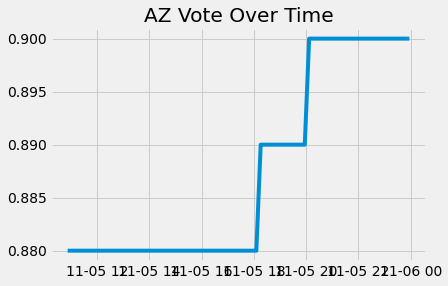

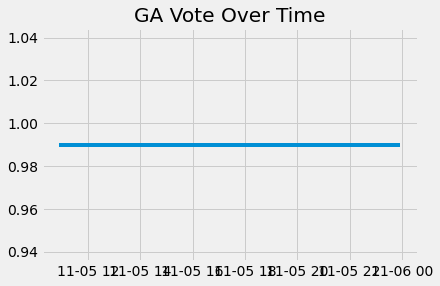

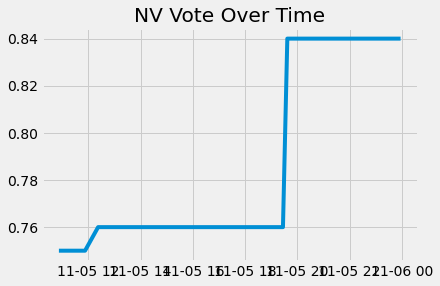

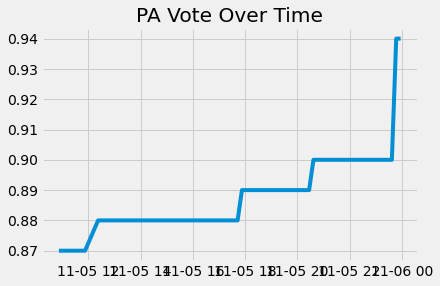

In [80]:
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_code = state_group[0]

    xs = state_data['Time']
    ys = state_data['Progress']

    plt.show()
    #Votes over Time
    plt.plot(xs,ys)
    plt.title(state_code + ' Vote Over Time')

## Conclusion : The Progress field is not great

# Lets Clean it

Since the "Progress" column is unreliable because numbers got stuck at certain percentages, lets adjust it.

Lets also make some rolling predictions to give us insight how the model would have performed at the time.

In [81]:
import numpy as np

adjusted = []
for state_group in data.groupby('State'):
    state_data = state_group[1]
    current_progress = state_data["Progress"].max()
    current_vote = state_data["Biden Vote"].max() + state_data["Trump Vote"].max() + state_data["Other Vote"].max()
    projected_total = current_vote * (1/current_progress)
    adjusted_progress = (state_data["Biden Vote"] + state_data["Trump Vote"] + state_data["Other Vote"]) / projected_total
    state_data["Adjusted Progress"] = adjusted_progress
    adjusted.append(state_data)

data = pd.concat(adjusted)



Lets see if that helped

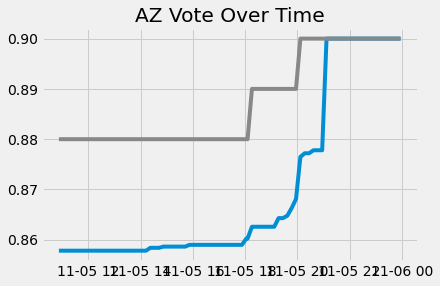

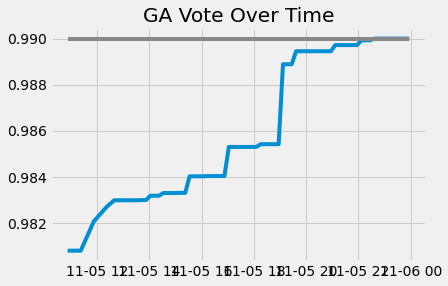

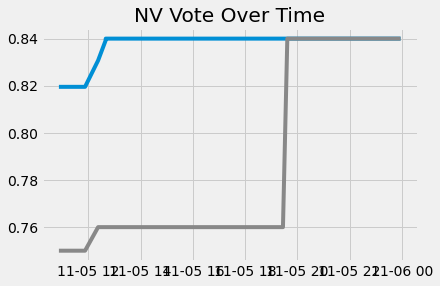

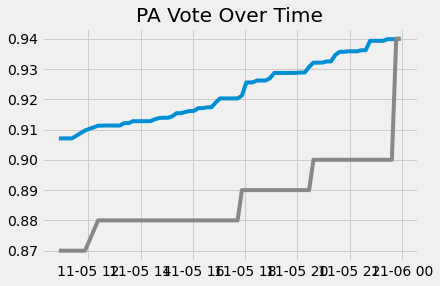

In [82]:
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_code = state_group[0]

    xs = state_data['Time']
    ys = state_data['Adjusted Progress']
    ys_2 = state_data['Progress']

    plt.show()
    #Votes over Time
    plt.plot(xs,ys)
    plt.plot(xs,ys_2, color="#888")
    plt.title(state_code + ' Vote Over Time')

I think that helped a lot. So with that new cleaning method lets reapply our predictions.

In [83]:
def roll_dem(df):
    dem_votes = df['Biden Vote']
    rep_votes = df['Trump Vote']
    ys = df['Adjusted Progress']
    predict_dem, predict_rep = predict_votes(dem_votes, rep_votes, ys)
    return predict_dem

def roll_rep(df):
    dem_votes = df['Biden Vote']
    rep_votes = df['Trump Vote']
    ys = df['Adjusted Progress']
    predict_dem, predict_rep = predict_votes(dem_votes, rep_votes, ys)
    return predict_rep

predicted = []
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_data["Biden Projection"] = rolling_apply(state_data, 50, roll_dem)
    state_data["Trump Projection"] = rolling_apply(state_data, 50, roll_rep)
    predicted.append(state_data)

data = pd.concat(predicted)
pd.options.display.float_format = '{:,.2f}'.format
print(data)

                          Time State Progress    Total Trump Share Trump Vote  \
0   2020-11-05 10:52:28.864410    AZ     0.88  2910053        0.48    1400951   
4   2020-11-05 11:22:29.041940    AZ     0.88  2910053        0.48    1400951   
8   2020-11-05 11:52:29.186225    AZ     0.88  2910053        0.48    1400951   
12  2020-11-05 12:22:29.322993    AZ     0.88  2910053        0.48    1400951   
16  2020-11-05 12:39:32.892565    AZ     0.88  2910053        0.48    1400951   
..                         ...   ...      ...      ...         ...        ...   
271 2020-11-05 23:16:57.836490    PA     0.90  6613509        0.50    3281842   
275 2020-11-05 23:26:57.961863    PA     0.90  6617374        0.50    3282826   
279 2020-11-05 23:36:58.100002    PA     0.90  6617374        0.50    3282826   
283 2020-11-05 23:46:58.239968    PA     0.94  6617374        0.50    3282826   
287 2020-11-05 23:56:58.365637    PA     0.94  6618628        0.50    3283184   

    Biden Share Biden Vote 

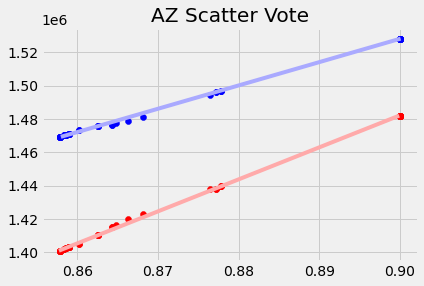

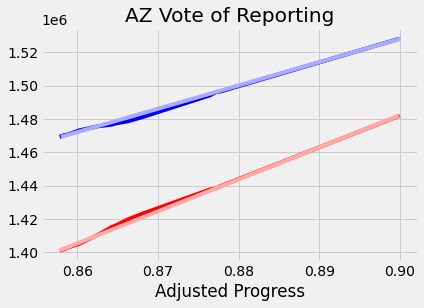

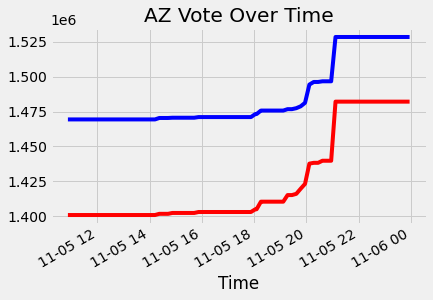

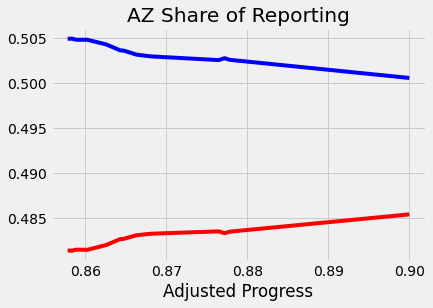

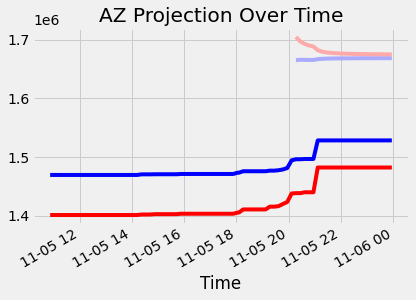

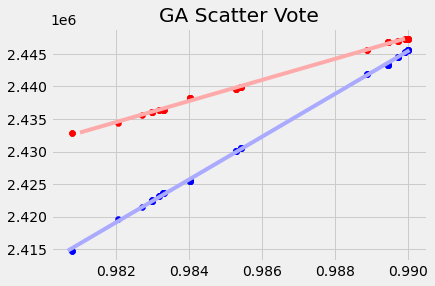

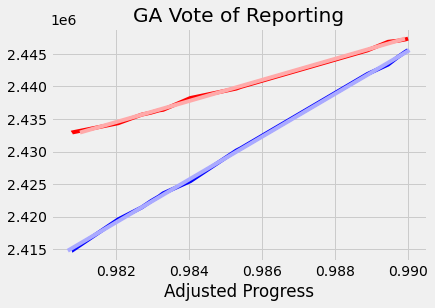

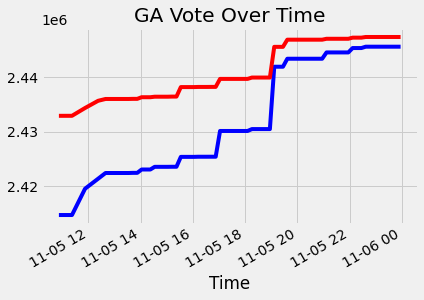

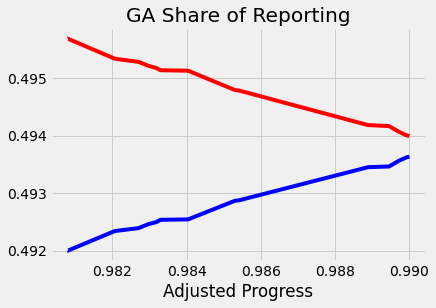

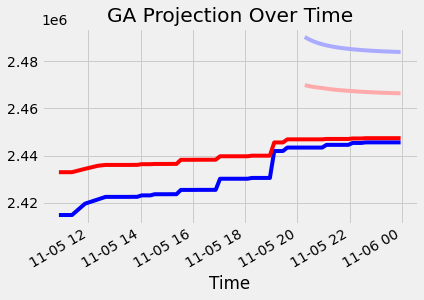

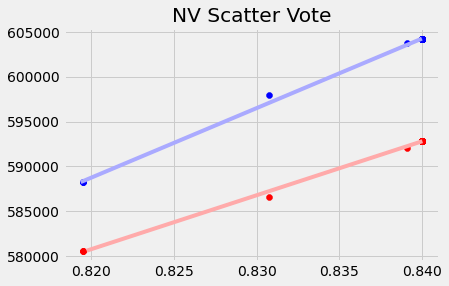

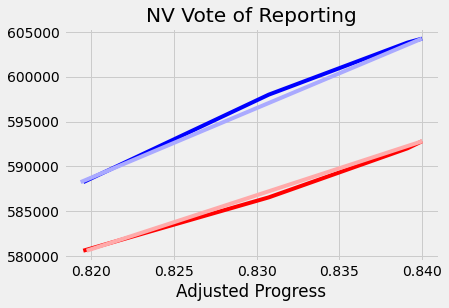

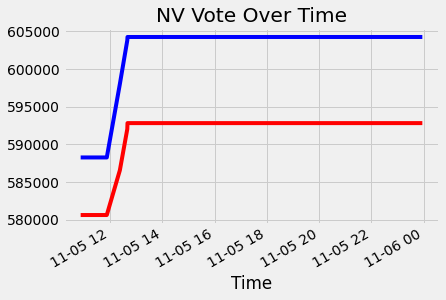

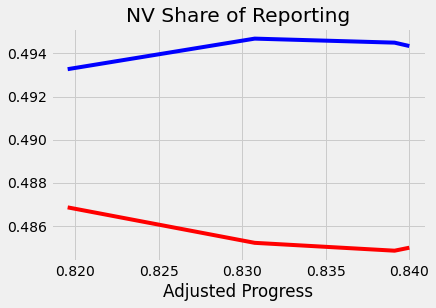

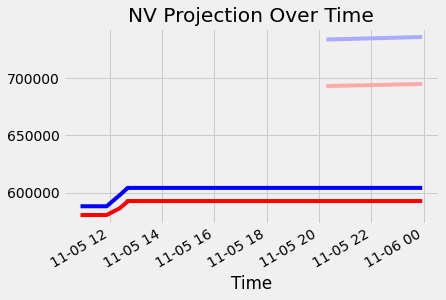

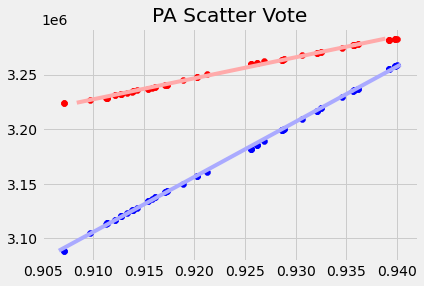

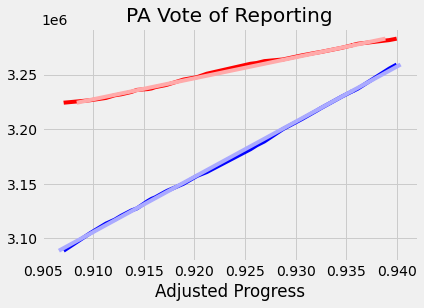

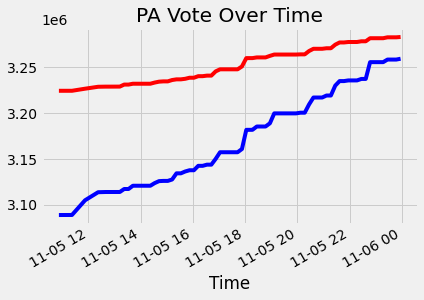

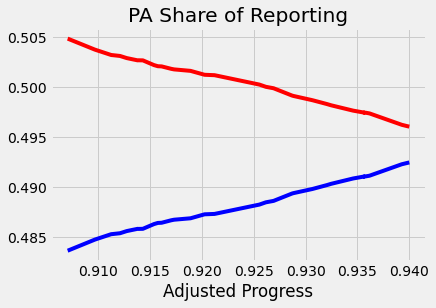

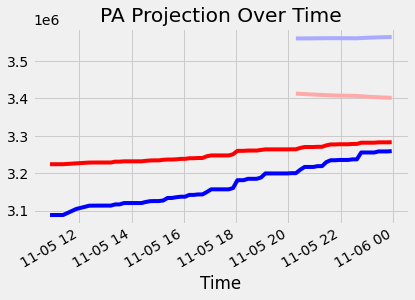

In [84]:
for state_group in data.groupby('State'):
    state_data = state_group[1]
    state_code = state_group[0]

    dem_votes = state_data['Biden Vote']
    rep_votes = state_data['Trump Vote']
    ys = state_data['Adjusted Progress']

    regression_line_dem = calculate_regression(dem_votes, ys)
    regression_line_rep = calculate_regression(rep_votes, ys)

    #Scatter
    plt.scatter(ys,dem_votes,color=color_dem,label='data')
    plt.scatter(ys,rep_votes,color=color_rep,label='data')
    plt.plot(regression_line_dem, dem_votes, color=color_pred_dem, label='regression line')
    plt.plot(regression_line_rep, rep_votes, color=color_pred_rep, label='regression line')
    plt.title(state_code + ' Scatter Vote')
    plt.show()

    #Votes v Progress
    state_data.plot(y=['Biden Vote', 'Trump Vote'], color=[color_dem, color_rep], x='Adjusted Progress', legend=None)
    plt.plot(regression_line_dem,dem_votes, color=color_pred_dem, label='regression line')
    plt.plot(regression_line_rep,rep_votes, color=color_pred_rep, label='regression line')
    plt.title(state_code + ' Vote of Reporting')

    plt.show()
    #Votes over Time
    state_data.plot(y=['Biden Vote', 'Trump Vote'], color=[color_dem, color_rep],x='Time', legend=None)
    plt.title(state_code + ' Vote Over Time')

    plt.show()
    #Share over Time
    state_data.plot(y=['Biden Share', 'Trump Share'], color=[color_dem, color_rep],x='Adjusted Progress', legend=None)
    plt.title(state_code + ' Share of Reporting')
    
    plt.show()

    #Projection over Time
    ax = state_data.plot(y=['Biden Projection', 'Trump Projection'], color=[color_pred_dem, color_pred_rep],x='Time', legend=None)
    state_data.plot(ax=ax,y=['Biden Vote', 'Trump Vote'], color=[color_dem, color_rep],x='Time', legend=None)
    plt.title(state_code + ' Projection Over Time')

    plt.show()

What can we learn from this?

- Cleaning the dataset and adjusting the progress to better match reality gave much better insight to how things would end
- More data, better predictions (looking at you Nevada)
- The model predicted GA,PA a day ahead of time
    - PA : Model - D: +165k, 11/20 - D: +82k
    - GA : Model - D : +2k , 11/20 - D: +13K
- This example was only 12 hours of data.
- The model was incorrect about Trump flipping AZ
- The original theory "The total, rate, and % of total votes are counted can predict the final count of votes" was mostly correct

Finally lets save it to a CSV to to more with later

In [85]:
data.to_csv('out.csv', index=False)  